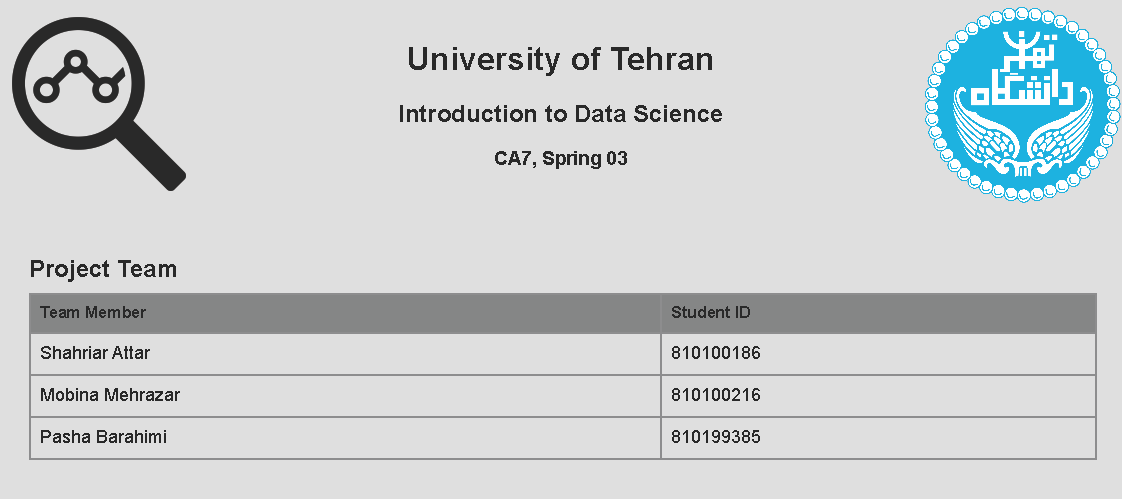

# Semi Supervised Learning and LLMs

## Table of Contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Tasks](#tasks)
- [Dataset Description](#dataset-description)
- [Environment Setup](#environment-setup)
- [EDA](#eda)
- [Feature Engineering](#feature-engineering)
- [Semi Supervised](#semi-supervised)
  - [Traditional Methods (Label Propagation)](#traditional-methods-label-propagation)
  - [LLMs](#llms)
  - [Evaluation](#evaluation)
- [Questions](#questions)
- [References](#references)

## Introduction

We have been employed at Amazon as a data scientist for its movie analysis department. In this assignment, we are given a dataset and asked to train a model to classify IMDb review comments automatically. First, we need to use different methods to expand our labeled data for training, extract features from sentences, and then train and evaluate our model.

## Objectives

This assignment aims to:

- Implementing traditional semi-supervised learning methods.
- Using LLMs to classify IMDb review comments.

## Tasks

- Perform EDA on the Dataset
- Feature Engineering
- Label Propagation
- Using LLMs for Semi-Supervised Learning

## Dataset Description

In real-world scenarios, the majority of data remains unlabeled, and labeling all of it can be prohibitively expensive. Instead, we label a portion of the data and attempt to extend these labels to other samples, constituting a semi-supervised task.

We are given a dataset containing information about movies and their user reviews on Amazon's movie platform.

The dataset comprises movie reviews submitted by users on IMDb for sentiment analysis tasks. Sentiment in movie comments refers to the overall emotional tone or attitude expressed towards a movie in a comment or review, which could be positive or negative. Positive sentiment might indicate enjoyment, appreciation, or excitement about the movie, while negative sentiment could suggest disappointment, dislike, or criticism.

This dataset is provided in a structured JSONL format. Each entry usually contains:

- The text of a review.
- Its corresponding sentiment label (1 for positive, 0 for negative).
- A feature vector (embedding) for each comment, which is used to train machine-learning models.

The dataset segments are as follows:

- Training dataset: We'll use this portion of the data to train our models.
- Test dataset: We'll use this portion of the data for validation.
- Augmentation dataset: This unlabeled portion of the data should be labeled using existing models (machine learning models or large language models) to augment our training dataset.

## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [ ]:
# %pip install -U transformers
# %pip install -U accelerate

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import trange

import re

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

from wordcloud import WordCloud
from PIL import Image

import torch
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModelForCausalLM

from typing import Union, Optional
from dataclasses import dataclass

import tabulate

In [3]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [4]:
sns.set_style("darkgrid")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
MODEL_ARGS = {
    "Name": "microsoft/Phi-3-mini-128k-instruct",
    "DType": torch.bfloat16,
}

TRAIN_DATASET_PATH = "../data/train_imdb.jsonl"
TEST_DATASET_PATH = "../data/test_imdb.jsonl"
AUGMENTATION_DATASET_PATH = "../data/aug_imdb_unlabeled.jsonl"

SELF_TRAINING_LABELS_PATH = "../data/aug_imdb_self_training.txt"
LLM_LABELS_PATH = "../data/aug_imdb_llm.txt"

LLM_EVALUATION_COUNT = 30
LLM_RESULTS_PATH = "../data/llm_results.txt"
LLM_CHECKPOINT_COUNT = 50

IMDB_LOGO_PATH = "../assets/imdb.png"

RANDOM_STATE = 42

In [9]:
df_train = pd.read_json(TRAIN_DATASET_PATH, lines=True)
df_test = pd.read_json(TEST_DATASET_PATH, lines=True)
df_aug = pd.read_json(AUGMENTATION_DATASET_PATH, lines=True)

In [10]:
len(df_train), len(df_test), len(df_aug)

(150, 150, 1014)

## EDA

Before we start building models, we need to take a close look at the data. This means examining information about movies and user reviews on Amazon. We want to understand what people are saying about the movies and what features they talk about the most. This helps us decide how to work with the data to build accurate models later on. We should also research how we can do EDA, on text data.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 150 entries, 0 to 149

Data columns (total 3 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   text       150 non-null    object

 1   label      150 non-null    int64 

 2   embedding  150 non-null    object

dtypes: int64(1), object(2)

memory usage: 3.6+ KB


In [10]:
df_train.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 150 entries, 0 to 149

Data columns (total 3 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   text       150 non-null    object

 1   label      150 non-null    int64 

 2   embedding  150 non-null    object

dtypes: int64(1), object(2)

memory usage: 3.6+ KB


In [12]:
df_test.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664000..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.07834710930000001, -0.279764235, 0.6189775..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.026243483600000003, 0.0843501..."


In [13]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1014 entries, 0 to 1013

Data columns (total 2 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   text       1014 non-null   object

 1   embedding  1014 non-null   object

dtypes: object(2)

memory usage: 16.0+ KB


In [14]:
df_aug.head()

,text,embedding
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000..."


In [11]:
def add_category_labels(df: pd.DataFrame) -> pd.DataFrame:
    df["category"] = df["label"].apply(lambda x: "positive" if x == 1 else "negative")
    return df

df_train = add_category_labels(df_train)
df_test = add_category_labels(df_test)

First, we should remove the HTML tags from the text data.

In [16]:
def check_html_tags(df: pd.DataFrame) -> set:
    html_tags = set()
    for i in range(len(df)):
        html_tags.update(re.findall(r"<[^>]+>", df.iloc[i]["text"]))
    return html_tags

html_tags_train = check_html_tags(df_train)
html_tags_test = check_html_tags(df_test)
html_tags_aug = check_html_tags(df_aug)

In [17]:
html_tags_train, html_tags_test, html_tags_aug

({'<br />'}, {'<br />'}, {'<br />'})

In [12]:
def remove_html_tags(text: str) -> str:
    return re.sub(r"<[^>]+>", " ", text)

df_train["text"] = df_train["text"].apply(remove_html_tags)
df_test["text"] = df_test["text"].apply(remove_html_tags)
df_aug["text"] = df_aug["text"].apply(remove_html_tags)

Now, let's check the distribution of the sentiment labels in the training dataset.

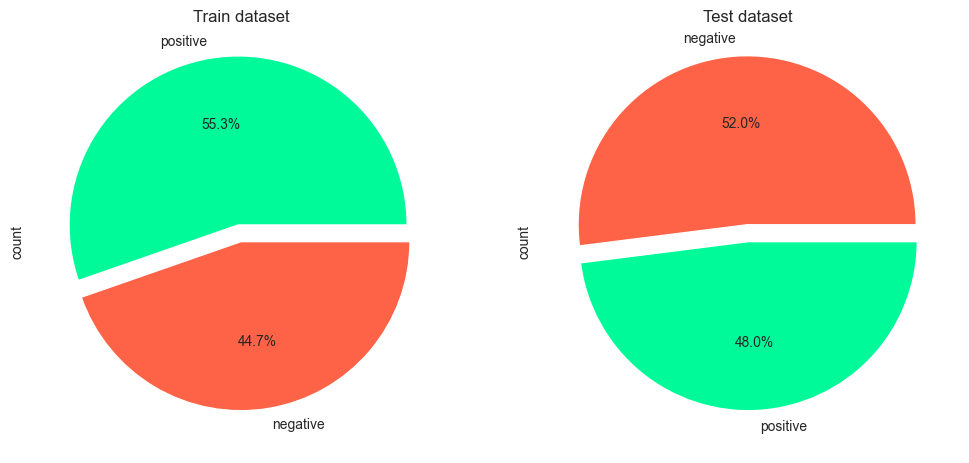

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df_train["category"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#00FA9A", "#FF6347"],
    explode=(0.1, 0),
    ax=ax[0],
)
ax[0].set_title("Train dataset")

df_test["category"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#FF6347", "#00FA9A"],
    explode=(0.1, 0),
    ax=ax[1],
)
ax[1].set_title("Test dataset")

plt.show()

As we can see, 55.3% of the reviews are positive, while 44.7% are negative. This is a balanced dataset, which is good for training machine learning models.

We can find the following features in the dataset:

- Length of the review.
- Number of words in the review.
- Average word length in the review.
- Average sentence length in the review.

Let's calculate these features and visualize them.

In [20]:
def plot_feature(df: pd.DataFrame, feature: str, title: str) -> None:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feature], hue=df["category"], palette=["#00FA9A", "#FF6347"])
    plt.title("Boxplot")
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, hue="category", palette=["#00FA9A", "#FF6347"], kde=True)
    plt.title("KDE plot")
    plt.suptitle(title)
    plt.show()

In [21]:
def with_length(df: pd.DataFrame) -> pd.DataFrame:
    df["length"] = df["text"].str.len()
    return df

In [22]:
df_train = with_length(df_train)
df_test = with_length(df_test)
df_aug = with_length(df_aug)

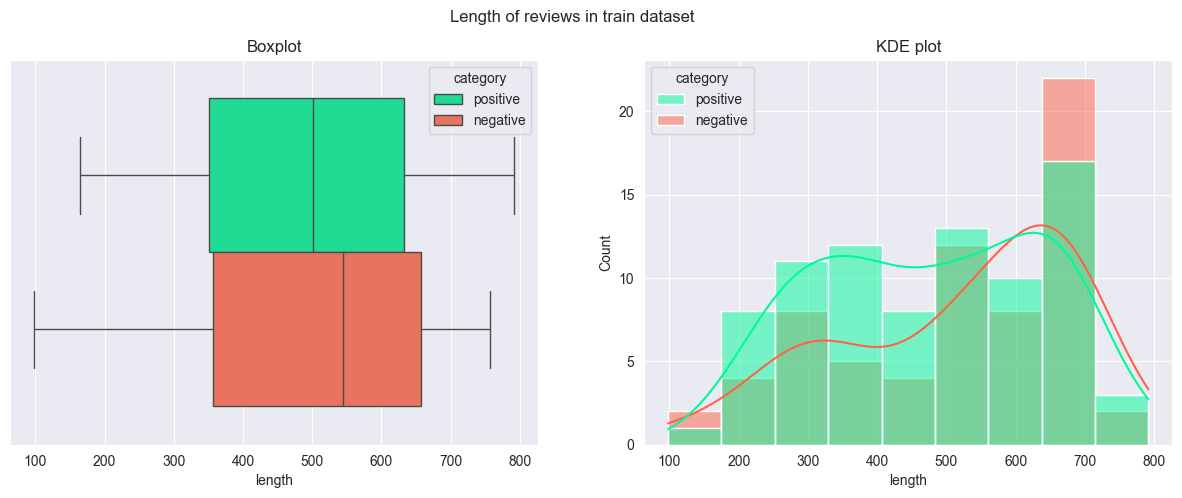

In [23]:
plot_feature(df_train, "length", "Length of reviews in train dataset")

In [24]:
def with_word_count(df: pd.DataFrame) -> pd.DataFrame:
    def count_words(text: str) -> int:
        return len(text.split())

    df["word_count"] = df["text"].apply(count_words)
    return df

df_train = with_word_count(df_train)
df_test = with_word_count(df_test)
df_aug = with_word_count(df_aug)

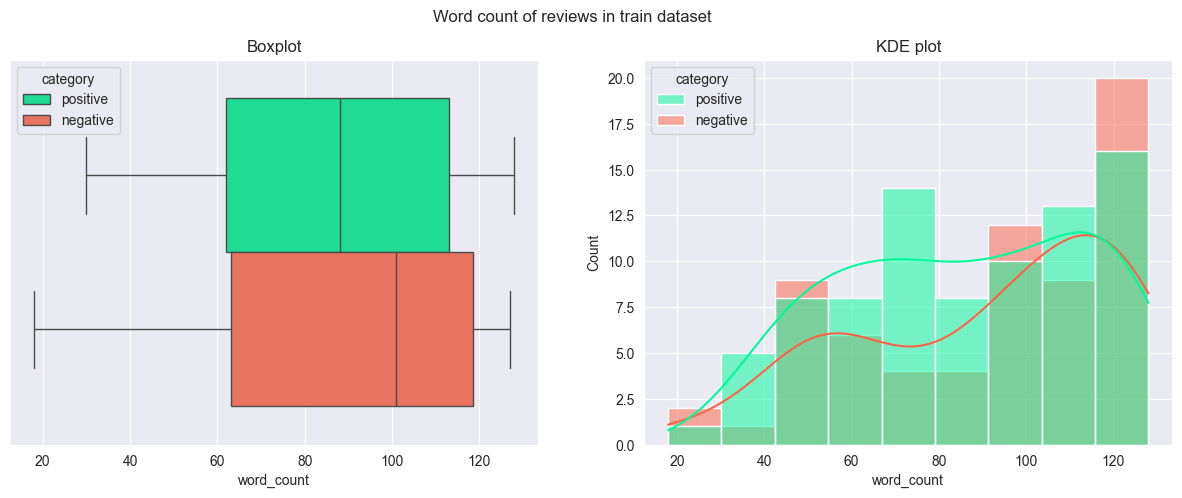

In [25]:
plot_feature(df_train, "word_count", "Word count of reviews in train dataset")

In [26]:
def with_avg_word_length(df: pd.DataFrame) -> pd.DataFrame:
    def avg_word_length(text: str) -> float:
        words = text.split()
        return sum(len(word) for word in words) / len(words)

    df["avg_word_length"] = df["text"].apply(avg_word_length)
    return df

df_train = with_avg_word_length(df_train)
df_test = with_avg_word_length(df_test)
df_aug = with_avg_word_length(df_aug)

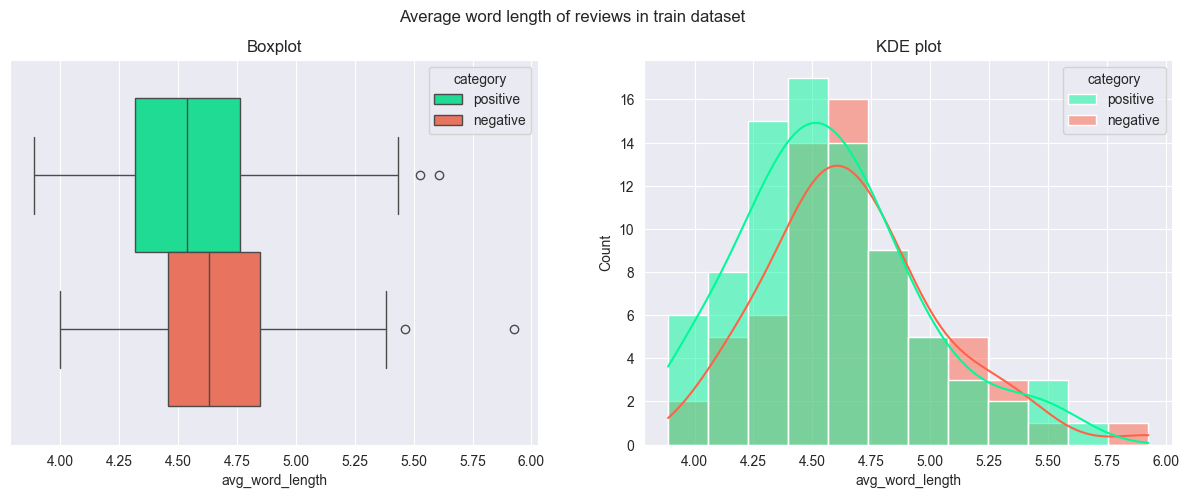

In [27]:
plot_feature(df_train, "avg_word_length", "Average word length of reviews in train dataset")

In [28]:
def with_avg_sentence_length(df: pd.DataFrame) -> pd.DataFrame:
    def avg_sentence_length(text: str) -> float:
        sentences = tokenize.sent_tokenize(text)
        return sum(len(sentence) for sentence in sentences) / len(sentences)

    df["avg_sentence_length"] = df["text"].apply(avg_sentence_length)
    return df

df_train = with_avg_sentence_length(df_train)
df_test = with_avg_sentence_length(df_test)
df_aug = with_avg_sentence_length(df_aug)

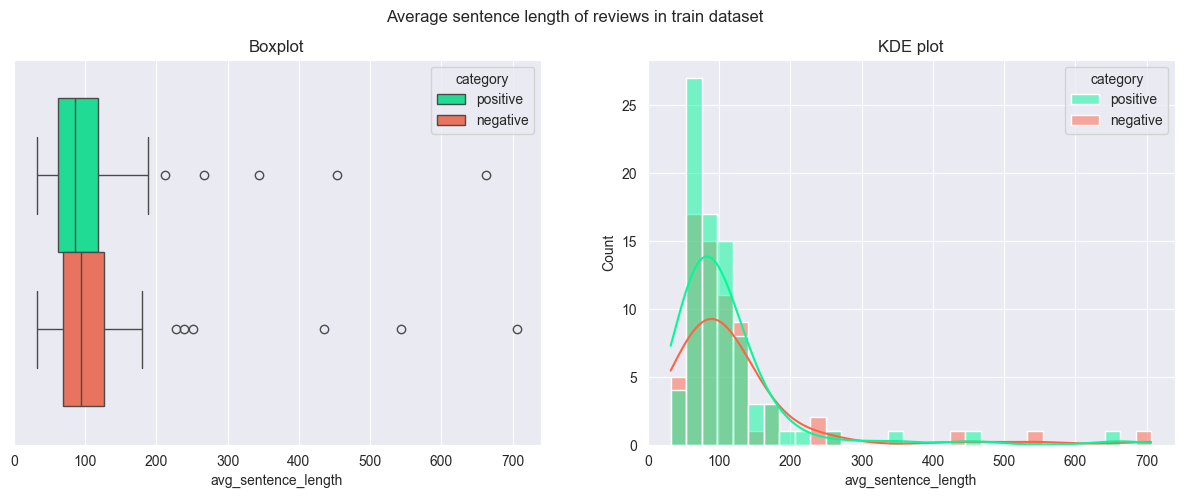

In [29]:
plot_feature(df_train, "avg_sentence_length", "Average sentence length of reviews in train dataset")

In [30]:
def with_avg_sentence_word_count(df: pd.DataFrame) -> pd.DataFrame:
    def avg_sentence_word_count(text: str) -> float:
        sentences = tokenize.sent_tokenize(text)
        return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

    df["avg_sentence_word_count"] = df["text"].apply(avg_sentence_word_count)
    return df

df_train = with_avg_sentence_word_count(df_train)
df_test = with_avg_sentence_word_count(df_test)
df_aug = with_avg_sentence_word_count(df_aug)

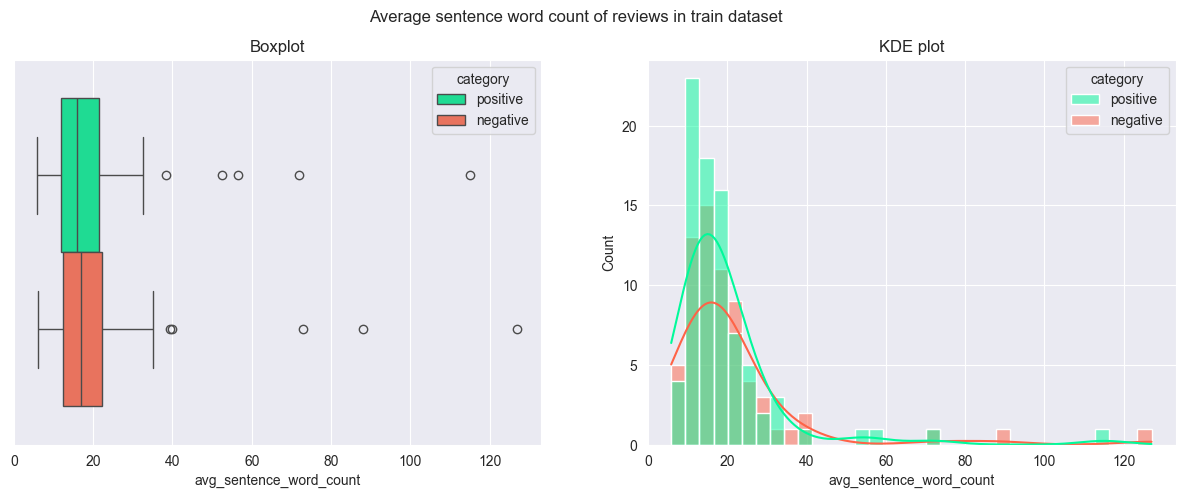

In [31]:
plot_feature(df_train, "avg_sentence_word_count", "Average sentence word count of reviews in train dataset")

In [32]:
print(f"Average Review Length:       {df_train['length'].mean():.2f}")
print(f"Average Word Count:          {df_train['word_count'].mean():.2f}")
print(f"Average Word Length:         {df_train['avg_word_length'].mean():.2f}")
print(f"Average Sentence Length:     {df_train['avg_sentence_length'].mean():.2f}")
print(f"Average Sentence Word Count: {df_train['avg_sentence_word_count'].mean():.2f}")

Average Review Length:       494.93

Average Word Count:          88.28

Average Word Length:         4.62

Average Sentence Length:     114.18

Average Sentence Word Count: 20.32


The default embedding size of `BERT` is 768. We can verify this by checking the length of the embedding for the reviews in the training dataset.

In [33]:
df_train["embedding"].apply(lambda x: len(x)).value_counts(), df_test["embedding"].apply(lambda x: len(x)).value_counts(), df_aug["embedding"].apply(lambda x: len(x)).value_counts()

(embedding
 768    150
 Name: count, dtype: int64,
 embedding
 768    150
 Name: count, dtype: int64,
 embedding
 768    1014
 Name: count, dtype: int64)

Now, let's dive deeper into the text data. Before doing that, we need to preprocess the text data by removing punctuation, converting all text to lowercase, and removing stopwords. We can also lemmatize the text data.

The difference between stemming and lemmatization is that lemmatization considers the context and converts the word to its meaningful base form, while stemming just removes the suffixes.

In [34]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z 0-9 ']", "", text)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text

In [35]:
def remove_stopwords(text: str, stopwords: set = set(stopwords.words("english"))) -> str:
    return " ".join([word for word in text.split() if word not in stopwords])

In [36]:
def lemmatize_text(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [37]:
def preprocess_text(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df["text"].apply(clean_text)
    df["text"] = df["text"].apply(remove_stopwords)
    df["text"] = df["text"].apply(lemmatize_text)
    return df

In [38]:
df_train = preprocess_text(df_train)
df_test = preprocess_text(df_test)
df_aug = preprocess_text(df_aug)

In [39]:
df_train.head(10)["text"]

0    fairly good romantic comedy think i've ever se...
1    dressed kill one best thriller ever made deali...
2    i'm glad user date liked movie coming forward ...
3    needed excuse get house paint dried left movie...
4    john candy's performance upon crime possibly b...
5    movie maybe really bad alot fun bad acting poo...
6    besides boring scene oppressive dark movie tri...
7    exactly sort saturday matinee serial loved wor...
8    slick prehays code still sassy would highly re...
9    like film lot wonderful chemistry actor tell s...
Name: text, dtype: object

In [40]:
df_aug.head(10)["text"]

0    relation fortier profiler fact police series v...
1    process trying establish audiences' empathy ja...
2    give movie 7 10 villain interesting role unkno...
3    best scifi seen 29 year watching scifi also be...
4    appalling piece rubbish people blubber good ye...
5    quite possibly francis veber one best comedy d...
6    film failed explore humanity animal left empty...
7    frailty810it's nonsensical title bill paxton d...
8    although remade several time movie classic see...
9    kid totally loved bill ted movie night bogus j...
Name: text, dtype: object

In [41]:
new_stopwords = {"i'm", "i've", "i'll"}

df_train["text"] = df_train["text"].apply(remove_stopwords, stopwords=new_stopwords)
df_test["text"] = df_test["text"].apply(remove_stopwords, stopwords=new_stopwords)
df_aug["text"] = df_aug["text"].apply(remove_stopwords, stopwords=new_stopwords)

In [42]:
df_train.head(10)["text"]

0    fairly good romantic comedy think ever seen me...
1    dressed kill one best thriller ever made deali...
2    glad user date liked movie coming forward unde...
3    needed excuse get house paint dried left movie...
4    john candy's performance upon crime possibly b...
5    movie maybe really bad alot fun bad acting poo...
6    besides boring scene oppressive dark movie tri...
7    exactly sort saturday matinee serial loved wor...
8    slick prehays code still sassy would highly re...
9    like film lot wonderful chemistry actor tell s...
Name: text, dtype: object

We can find the most common words in the reviews.

In [43]:
def get_most_common_words(df_train: pd.DataFrame, df_aug: pd.DataFrame, n: int = 20) -> list:
    words = " ".join(df_train["text"]).split()
    words += " ".join(df_aug["text"]).split()
    return Counter(words).most_common(n)

In [44]:
most_common_words = get_most_common_words(df_train, df_aug, 40)
most_common_words

[('movie', 1522),
 ('film', 934),
 ('one', 618),
 ('like', 450),
 ('good', 407),
 ('time', 309),
 ('story', 286),
 ('see', 281),
 ('bad', 261),
 ('make', 256),
 ('great', 250),
 ('even', 248),
 ('really', 241),
 ('character', 221),
 ('scene', 215),
 ('would', 214),
 ('watch', 211),
 ('get', 207),
 ('think', 206),
 ('acting', 204),
 ('people', 199),
 ('well', 196),
 ('seen', 195),
 ('made', 194),
 ('best', 186),
 ('much', 179),
 ('show', 173),
 ('plot', 172),
 ('way', 171),
 ('first', 169),
 ('ever', 168),
 ('love', 164),
 ('actor', 157),
 ('could', 149),
 ('also', 148),
 ('better', 144),
 ('thing', 144),
 ('go', 143),
 ('funny', 139),
 ('never', 137)]

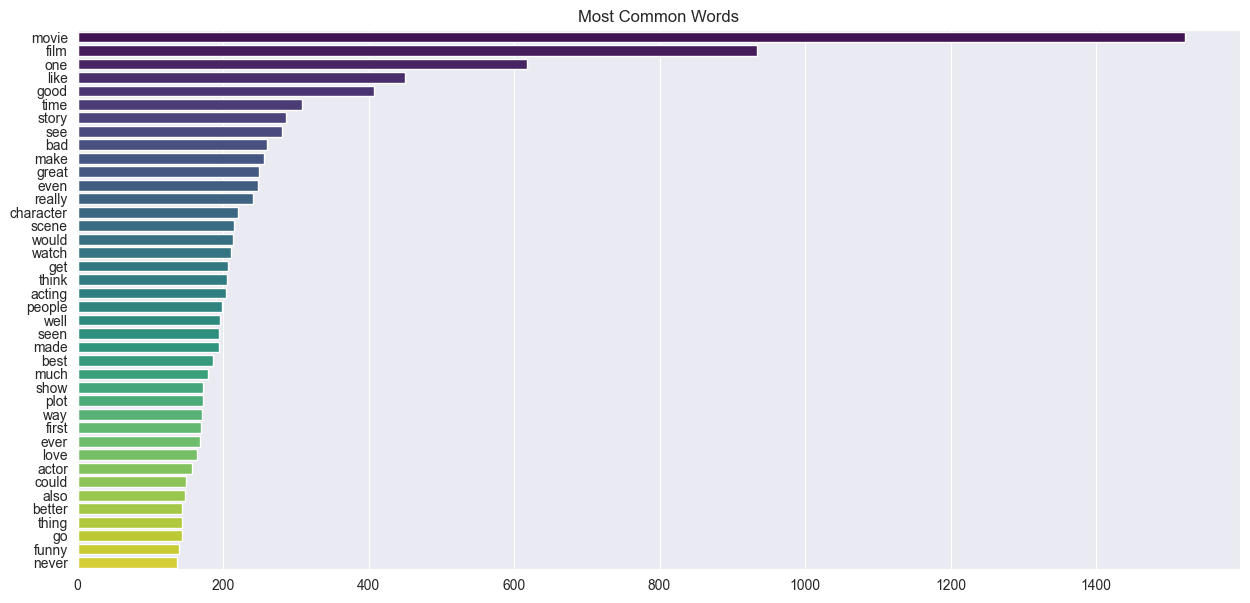

In [45]:
plt.figure(figsize=(15, 7))
sns.barplot(x=[word[1] for word in most_common_words], y=[word[0] for word in most_common_words], palette="viridis", hue=[word[0] for word in most_common_words], legend=False)
plt.title("Most Common Words")
plt.show()

Sometimes, using n-grams can help us understand the context of the text better. Let's use bigrams and trigrams to find the most common n-grams in the reviews.

In [46]:
def get_n_grams(df: pd.DataFrame, n: int = 2, top_n: int = 20) -> list:
    n_grams = []
    for text in df["text"]:
        text_n_grams = list(nltk.ngrams(text.split(), n))
        text_n_grams = [" ".join(n_gram) for n_gram in text_n_grams]
        n_grams += text_n_grams
    return Counter(n_grams).most_common(top_n)

In [47]:
train_bigrams = get_n_grams(df_train, n=2)

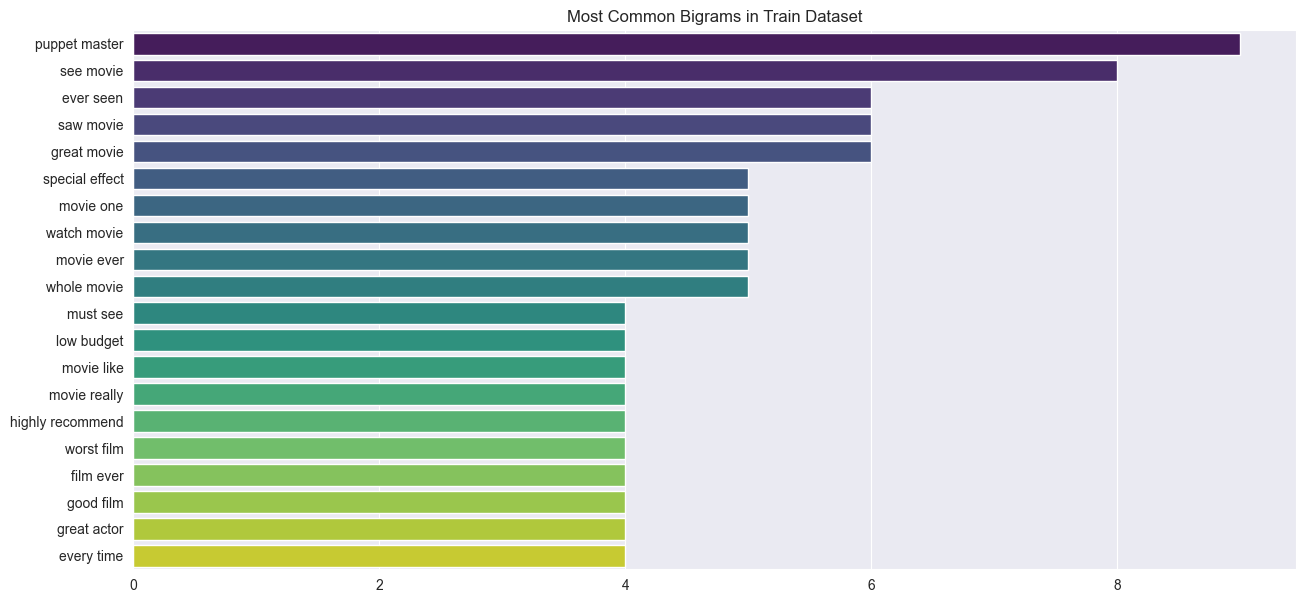

In [48]:
plt.figure(figsize=(15, 7))
sns.barplot(x=[bigram[1] for bigram in train_bigrams], y=[bigram[0] for bigram in train_bigrams], hue=[bigram[0] for bigram in train_bigrams], palette="viridis", legend=False)
plt.title("Most Common Bigrams in Train Dataset")
plt.show()

In [49]:
aug_bigrams = get_n_grams(df_aug, n=2)
aug_trigrams = get_n_grams(df_aug, n=3)

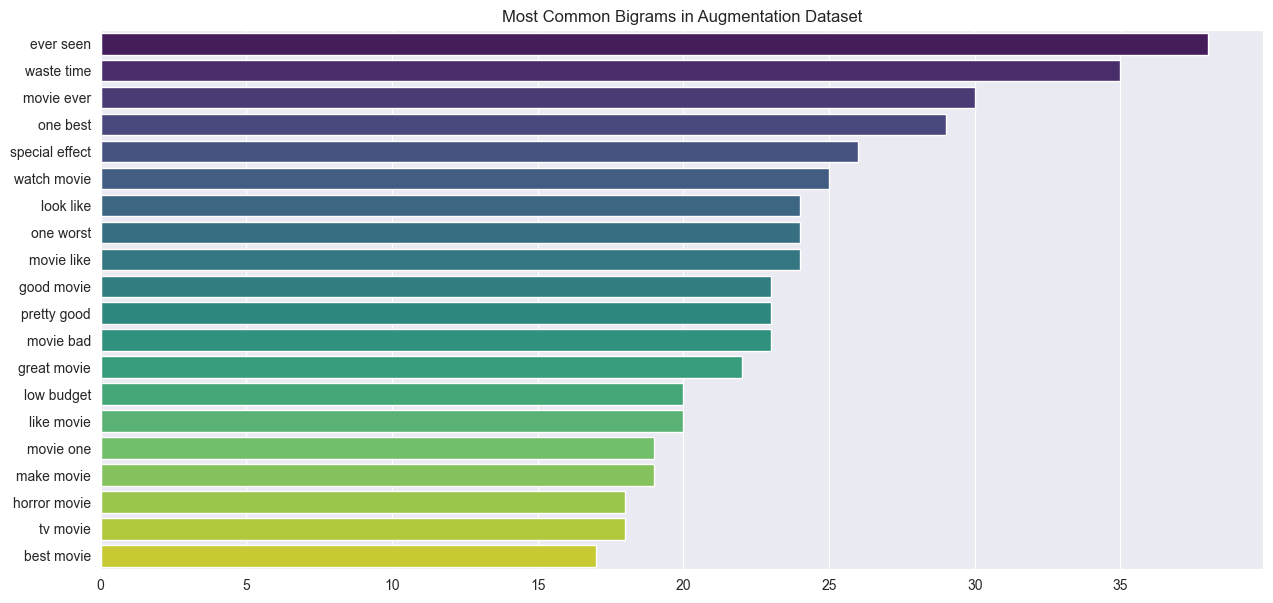

In [50]:
plt.figure(figsize=(15, 7))
sns.barplot(x=[bigram[1] for bigram in aug_bigrams], y=[bigram[0] for bigram in aug_bigrams], hue=[bigram[0] for bigram in aug_bigrams], palette="viridis", legend=False)
plt.title("Most Common Bigrams in Augmentation Dataset")
plt.show()

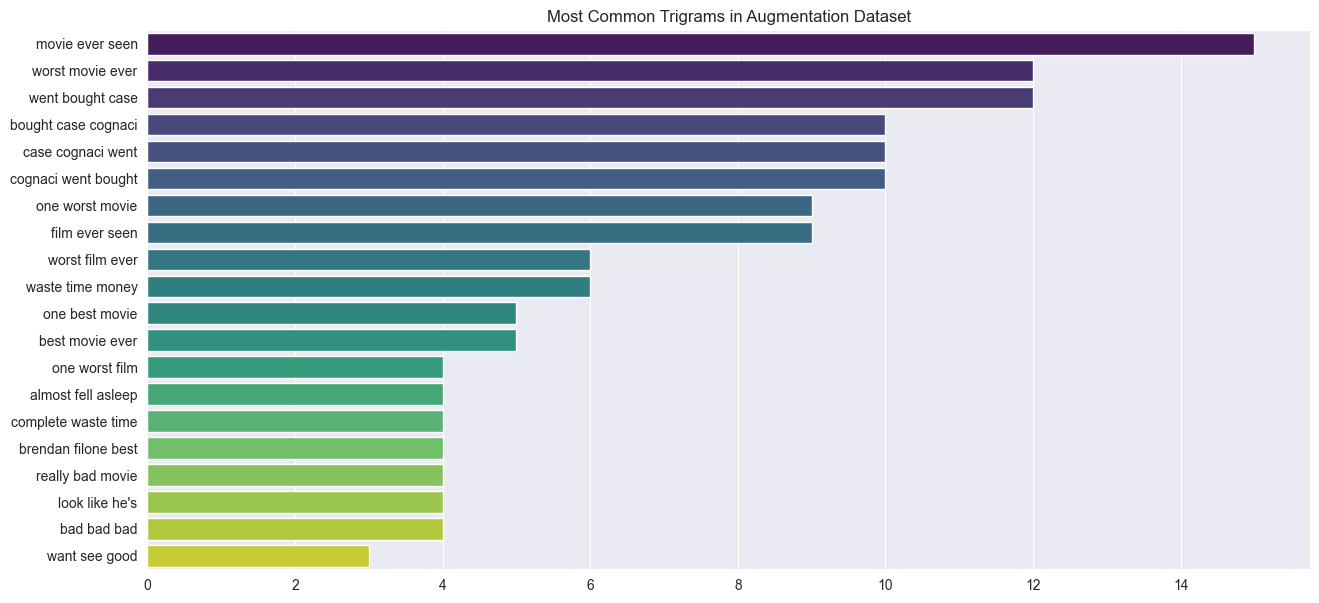

In [51]:
plt.figure(figsize=(15, 7))
sns.barplot(x=[trigram[1] for trigram in aug_trigrams], y=[trigram[0] for trigram in aug_trigrams], hue=[trigram[0] for trigram in aug_trigrams], palette="viridis", legend=False)
plt.title("Most Common Trigrams in Augmentation Dataset")
plt.show()

In [52]:
tsne_2d = TSNE(n_components=2, random_state=RANDOM_STATE)

In [53]:
def plot_tsne_2d(df: pd.DataFrame, title: str) -> None:
    embeddings = np.array(df["embedding"].tolist())
    tsne_embeddings = tsne_2d.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=tsne_embeddings[:, 0],
        y=tsne_embeddings[:, 1],
        hue=df["category"],
        palette=["#00FA9A", "#FF6347"],
        alpha=0.7,
    )
    plt.title(title)
    plt.show()

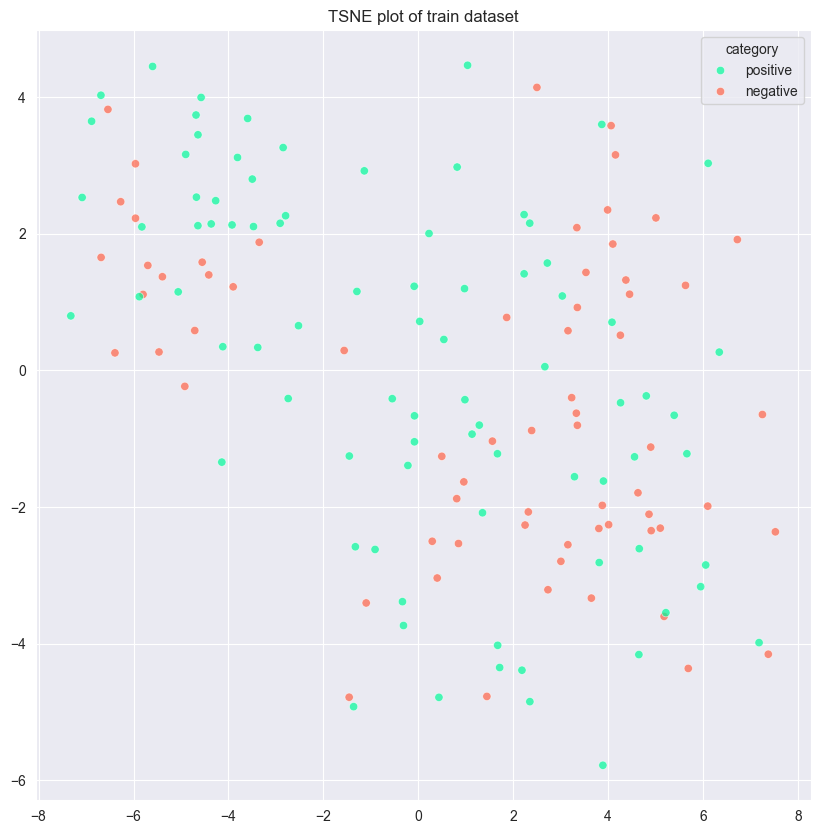

In [54]:
plot_tsne_2d(df_train, "TSNE plot of train dataset")

In [55]:
tnse_3d = TSNE(n_components=3, random_state=RANDOM_STATE)

In [56]:
def plot_tsne_3d(df: pd.DataFrame, title: str) -> None:
    embeddings = np.array(df["embedding"].tolist())
    tsne_embeddings = tnse_3d.fit_transform(embeddings)

    fig = px.scatter_3d(
        x=tsne_embeddings[:, 0],
        y=tsne_embeddings[:, 1],
        z=tsne_embeddings[:, 2],
        color=df["category"],
        title=title,
        labels={"color": "Category"},
    )
    fig.show()

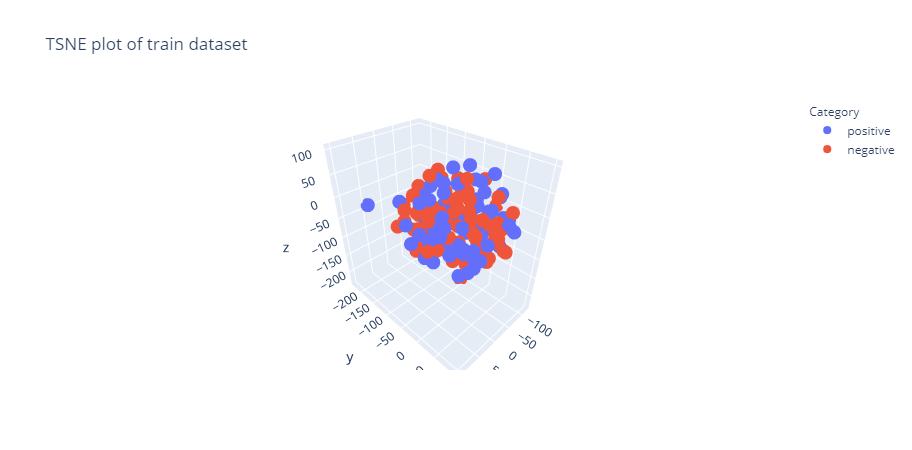

In [57]:
plot_tsne_3d(df_train, "TSNE plot of train dataset")

In [58]:
similarity_matrix = cosine_similarity(np.array(df_train["embedding"].tolist()))

In [59]:
def get_similar_reviews(df: pd.DataFrame, index: int, similarity_matrix: np.ndarray, n: int = 5):
    similar_reviews = np.argsort(similarity_matrix[index])[::-1][1 : n + 1]

    print(f"Review: {df.iloc[index]['text']} -> Category: {df.iloc[index]['category']}\n")
    for i, review in enumerate(similar_reviews):
        print(f"Similar Review {i + 1}: {df.iloc[review]['text']} -> Category: {df.iloc[review]['category']}\n")

In [60]:
get_similar_reviews(df_train, 0, similarity_matrix)

Review: fairly good romantic comedy think ever seen meg looking cuter player good job keeping lively romp course real world genius mathematician would even glance grease monkey love romantic comediesone totally forget reality good time nice film damn meg babe eh -> Category: positive



Similar Review 1: male given women's movie really well done special story personal love jane fonda person one hell fine job deniro usual superb self everything well done acting directing visuals setting photography casting enjoy story real people real love winner -> Category: positive



Similar Review 2: opening sequence alone worth cost admission cheech chong drag big ol garbage across parking lot filled gas spill man hilarious stuff 'the plot' ensues one heck ride watched film recently hold funny upon viewing check -> Category: positive



Similar Review 3: compare two version hamlet shakespeare class unfortunately picked version everything acting actor deliver line directly camera camera shot medium

In [61]:
get_similar_reviews(df_train, 33, similarity_matrix)

Review: thought excellent honest portrayal paralysis racism movie never pander audience never get predictable acting topnotch movie reminded one flew cuckoo's nest -> Category: positive



Similar Review 1: really enjoyed movie script fresh unpredictable acting outstandingit downtoearth movie character one care brought tear eye time left great feeling afterwards -> Category: positive



Similar Review 2: thought movie extremely funny actually interesting raw honest felt really watching real people actor great entertainment also painted people human level u good film -> Category: positive



Similar Review 3: film thought great journey forrest gump rare treat watch cable movie middle day come across foreign film done well film well acted strongly suggest anyone take subtitle -> Category: positive



Similar Review 4: really shame film like never snag best picture nomination one simply winner far consistently hilarious comedy ever seen screenplay design impeccable mention incredible cast

Let's generate a wonderful word cloud to visualize the most common words in the reviews =)

In [62]:
def plot_wordcloud(df: pd.DataFrame, mask_path: Optional[str] = None) -> None:
    mask = np.array(Image.open(mask_path)) if mask_path else None
    wc = WordCloud(
        background_color="white",
        mask=mask,
        contour_width=1,
        contour_color="black",
        max_words=200,
    ).generate(" ".join(df["text"]))

    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

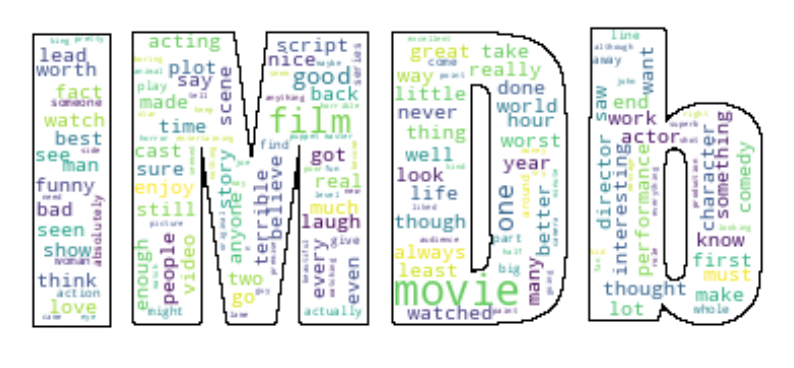

In [63]:
plot_wordcloud(df_train, IMDB_LOGO_PATH)

We can have two word clouds, one for positive reviews and one for negative reviews.

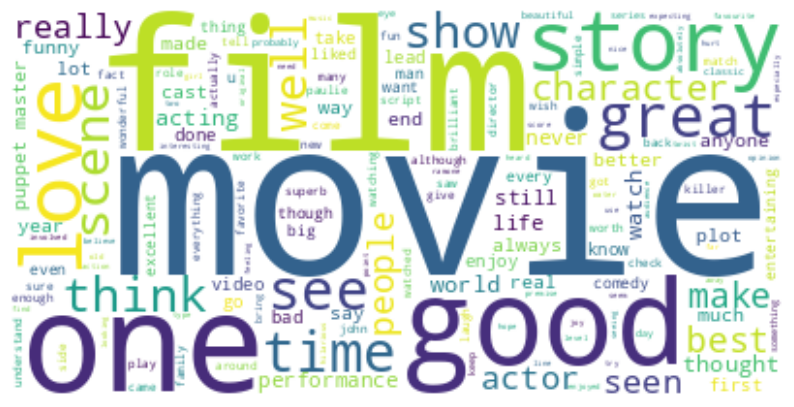

In [64]:
plot_wordcloud(df_train[df_train["category"] == "positive"])

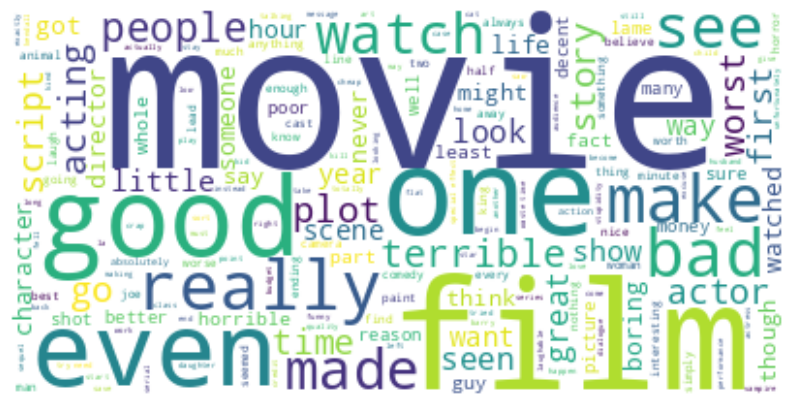

In [65]:
plot_wordcloud(df_train[df_train["category"] == "negative"])

We can see the difference between the most common words in positive and negative reviews. For example, the word "good" is more common in positive reviews, while the word "bad" is more common in negative reviews.

## Feature Engineering

We'll explore methods for extracting features from text data and provide a brief explanation of each. The TAs have already added these embedding features to each sentence in the dataset to simplify the complexity of NLP tasks, allowing us to focus on other aspects of our work. It's up to us how we want to use these features along the way.

Some common methods for extracting features from text data:

1. **Bag of Words (BoW)**: This is the simplest way of converting text data into numerical features. It involves two things: A vocabulary of known words and a measure of the presence of known words. It does not consider the order of words, just their frequency.

2. **Term Frequency-Inverse Document Frequency (TF-IDF)**: This is a more advanced way to convert text data into numerical features. It not only considers the frequency of words in a single document (or row in your dataset) but also in all documents in your dataset. It gives more weight to words that are frequent in a document but rare in all documents, which can help highlight words that are more interesting in a particular context.

3. **Word Embeddings (Word2Vec, GloVe)**: These are modern ways to represent words as vectors in a high-dimensional space. Words that are semantically similar are close to each other in this space. These methods consider the context of words and can capture complex semantic relationships.

![1SYiW1MUZul1NvL1kc1RxwQ.png](<attachment:1SYiW1MUZul1NvL1kc1RxwQ.png>)

4. **Topic Modeling (Latent Dirichlet Allocation, LDA)**: This is a type of model that finds groups of words that often appear together across multiple documents. These groups of words can be interpreted as "topics", and each document can be described by the topics that appear in it.

5. **N-grams**: An N-gram is a contiguous sequence of n items from a given sample of text or speech. N-grams of texts are extensively used in text mining and natural language processing tasks. They are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward.

6. **Part-of-Speech (POS) Tagging**: This involves identifying the part of speech (noun, verb, adjective, etc.) of each word in your text data. This can be useful in understanding the grammatical structure of sentences and in reducing the vocabulary of your text data by, for example, only considering certain parts of speech.

7. **Named Entity Recognition (NER)**: This is the process of locating named entities in the text (such as persons, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.) and classifying them into predefined categories.
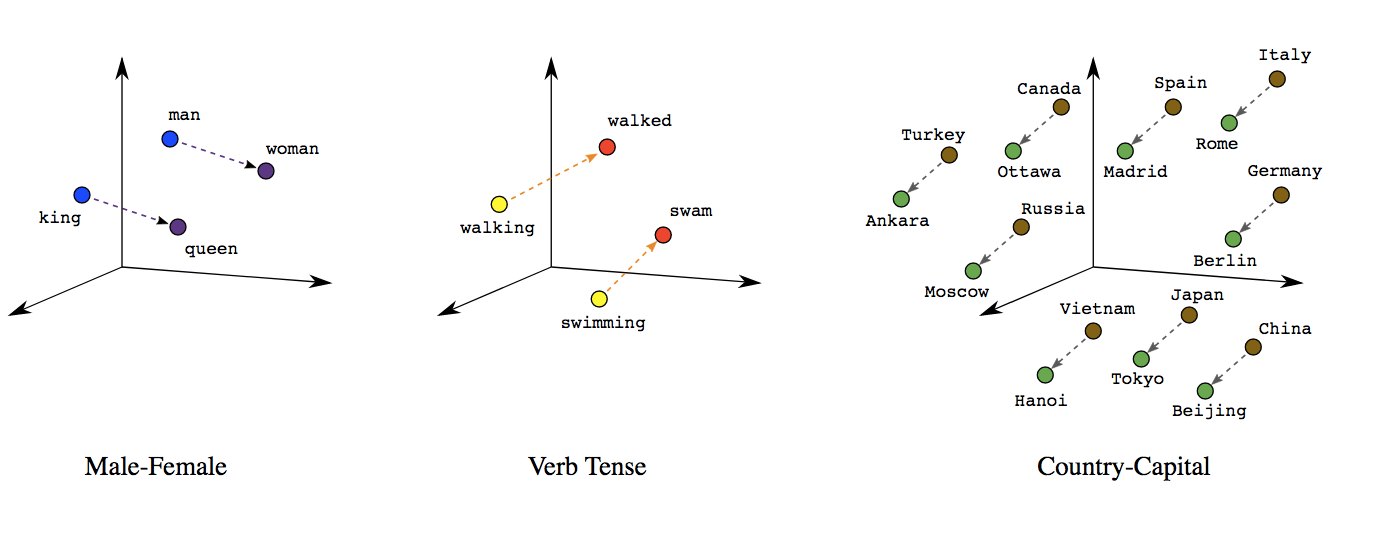

Since we already have the embeddings for each sentence in the dataset, we can use these features to train our models, and we don't need to extract features from the text data.

## Semi Supervised

We have learned that supervised learning involves training a model on a labeled dataset, where each example is paired with an output label, while unsupervised learning deals with unlabeled data and aims to find hidden patterns or structures. Semi-supervised learning is a hybrid approach that combines both methods. It uses a small amount of labeled data along with a large amount of unlabeled data to improve learning accuracy. This approach leverages the labeled data to guide the learning process and the unlabeled data to capture the underlying data distribution, making it particularly useful when labeling data is expensive or time-consuming.

### Traditional Methods (Label Propagation)

We should research label propagation techniques and their traditional methods. We'll utilize one of these methods, such as KMeans, to propagate labels for unlabeled data. Next, we will train a model using the extracted features and propagate labels as desired (whether using only hand-labeled data or a combination of labeled and propagated labels is up to us).

In [66]:
X_labeled = df_train["embedding"]
y_labeled = df_train["label"]

X_unlabeled = df_aug["embedding"]

In [67]:
X_labeled = np.array([np.array(embedding) for embedding in X_labeled])
X_unlabeled = np.array([np.array(embedding) for embedding in X_unlabeled])

In [68]:
X_labeled.shape, y_labeled.shape, X_unlabeled.shape

((150, 768), (150,), (1014, 768))

In [69]:
parameters = {
    "C": [0.1, 1, 2, 5, 10, 100, 200, 500, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4],
    "probability": [True, False],
    "random_state": [RANDOM_STATE],
}

svc = SVC()

grid_search = GridSearchCV(svc, parameters, n_jobs=-1, cv=5, verbose=1, scoring="accuracy")
grid_search.fit(X_labeled, y_labeled)
grid_search.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


{'C': 500,
 'degree': 2,
 'gamma': 'auto',
 'kernel': 'rbf',
 'probability': True,
 'random_state': 42}

In [70]:
svm = grid_search.best_estimator_
self_training_model = SelfTrainingClassifier(svm)
self_training_model.fit(
    np.concatenate((X_labeled, X_unlabeled)),
    np.concatenate((y_labeled, [-1 for _ in range(len(X_unlabeled))])),
)

SelfTrainingClassifier(base_estimator=SVC(C=500, degree=2, gamma='auto',
                                          probability=True, random_state=42))

In [71]:
y_unlabeled_self_training = self_training_model.predict(X_unlabeled)

with open(SELF_TRAINING_LABELS_PATH, "w") as file:
    for label in y_unlabeled_self_training:
        file.write(f"{label}\n")

### LLMs

For working with LLMs, the TAs suggest us look at the [documentation](https://huggingface.co/docs) on the Hugging Face website. Hugging Face is a leading platform for natural language processing, offering high-level libraries like [Transformers](https://huggingface.co/docs/transformers/index). The Transformers library provides pre-trained models and tools that simplify implementing and fine-tuning state-of-the-art language models for various NLP tasks, such as text classification, translation, and question-answering. This library makes it easy to leverage powerful models without needing deep expertise in machine learning, accelerating your development process. For more information, they suggest us check [this](https://huggingface.co/docs/transformers/llm_tutorial) tutorial on how to use LLMs.

Now, let's integrate an LLM (Large Language Model) for label generation. We should research how an LLM can be applied to a specific task like classification and explain the circumstances under which each method should be used.

We should also beware that using an LLM can be time consuming, so need to save our results. Just like the previous step, we'll train a model using the extracted features and new labeled dataset (we can even use the LLM as your classifier!).

For this task, we are going to use prompt engineering methods to generate labels with the [Phi-3](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct) model. The TAs have already implemented a function to load the model for us, so we don't need to worry about that.

In [13]:
def load_model(model_args: dict) -> tuple:

    model = AutoModelForCausalLM.from_pretrained(
        model_args["Name"],
        trust_remote_code=True,
        torch_dtype=model_args["DType"],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_args["Name"],
        trust_remote_code=True,
    )

    return model, tokenizer

In [ ]:
model, tokenizer = load_model(MODEL_ARGS)

In [15]:
def generate_text(model: Union[torch.nn.Module, torch.nn.DataParallel], tokenizer: AutoTokenizer, prompt: str, max_new_tokens: int = 100, do_sample: bool = True, temperature: float = 0.5) -> str:
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text[len(prompt):]

In [34]:
def get_sentiment(answer: str) -> str:
    positive_words = ["Positive", "Mostly Positive"]
    negative_words = ["Negative", "Mostly Negative", "Mixed", "Neutral"]
    for word in positive_words:
        if answer.startswith(f"Answer: {word}"):
            return "positive"
    for word in negative_words:
        if answer.startswith(f"Answer: {word}"):
            return "negative"
    return "unknown"

In [17]:
def get_checkpoint_idx(file_path: str = LLM_RESULTS_PATH) -> int:
    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        open(file_path, "w").close()
        return 0

In [18]:
def save_checkpoint(answers: list[str], file_path: str = LLM_RESULTS_PATH):
    with open(file_path, "a") as file:
        for answer in answers:
            answer = answer.replace("\n", " ")
            file.write(f"{answer}\n")

In [19]:
question_template = "Question: What is the sentiment of the following review `{review}` (Positive/Negative)?\n"
answer_template = "Answer: {answer}\n"
qa_template = question_template + answer_template

In [20]:
review_1 = "fairly good romantic comedy in which i don't think i've ever seen meg looking any cuter. all the players did a good job at keeping this a lively romp. of course, in the real world no genius mathematician would even glance at some grease monkey, but that is why i love romantic comedies....one can just totally forget reality and have a good time. nice film. damn, meg is a babe, eh?"
answer_1 = "Positive, it contains several affirmative phrases and expressions of enjoyment. The reviewer describes the film as a \"fairly good romantic comedy\" and praises the actors for doing \"a good job at keeping this a lively romp.\" Additionally, the reviewer expresses personal enjoyment and escapism by stating they love romantic comedies for allowing them to \"totally forget reality and have a good time.\" Finally, the reviewer specifically compliments Meg Ryan's appearance multiple times, indicating a positive reaction to her performance. Overall, these positive comments reflect the reviewer's favorable impression of the film."
train_1 = qa_template.format(review=review_1, answer=answer_1)

review_2 = "besides being boring, the scenes were oppressive and dark. the movie tried to portray some kind of moral, but fell flat with its message. what were the redeeming qualities?? on top of that, i don't think it could make librarians look any more unglamorous than it did."
answer_2 = "Negative, it contains several critical and disapproving remarks. The reviewer describes the movie as \"boring\" and the scenes as \"oppressive and dark,\" indicating a lack of enjoyment and a negative viewing experience. They further criticize the film's attempt to convey a moral, stating that it \"fell flat with its message,\" which suggests that the movie failed in its intended purpose. The rhetorical question \"what were the redeeming qualities??\" implies that the reviewer found nothing positive about the film. Additionally, the reviewer disparages the portrayal of librarians as \"unglamorous,\" adding another layer of negativity. These comments collectively reflect a highly unfavorable opinion of the film."
train_2 = qa_template.format(review=review_2, answer=answer_2)

review_3 = "this film was the worst film i have ever viewed. it was like a \"homework assignment\" for a film class. it totally misses the mark when it comes to the \"message\" it is trying to relay. characters are over exaggerated, poor acting and as for a plot...well it is utterly ridiculous. the cover shot is what made me think it may be a decent film, the co-actor is handsome and that's about it. moral of this movie: never judge a movie by it's cover! save your time, money and energy and make your own home movie and you will be far better off than i. it was painful to watch and quite frankly i am surprised that anyone would spend money to make and distribute it!"
answer_3 = "Negative, describing the film as the worst the reviewer has ever seen. They criticize it for feeling like an amateur film class project, missing its intended message, featuring exaggerated characters and poor acting, and having a ridiculous plot. The reviewer regrets being misled by the cover and a handsome co-actor, advises others not to waste their time and money, and finds it surprising that the film was made and distributed. Overall, they found watching the movie to be a painful experience."
train_3 = qa_template.format(review=review_3, answer=answer_3)

review_4 = "and gi joe go stuck in the water, i die of laufther every time i see this movie, and then a big brown shark came, this is comedy at it's best, this blows away the kings of comedy and anyone else, andrew dice clay, jerry, tucker, rock, they can't thouch the man the myth the legend eddie murphy, yo eddie we want more more more more more more more !!!!!!!!!!!!!!!!!!!!!!!!!!"
answer_4 = "Positive, it is filled with enthusiastic praise and expressions of enjoyment. The reviewer mentions they \"die of laughter every time\" they watch the movie, indicating it consistently entertains them. They call it \"comedy at its best\" and state it \"blows away the kings of comedy and anyone else,\" showing a strong preference for this film over others. Additionally, they praise Eddie Murphy as \"the man the myth the legend,\" and end with a passionate call for \"more more more,\" emphasizing their admiration and desire for more content from him. These positive and enthusiastic comments clearly reflect a highly favorable opinion."
train_4 = qa_template.format(review=review_4, answer=answer_4)

review_5 = "this is the worst movie i have seen for years! it starts ridicoulus and continues in the same way. i thnik when is something going to happen in this film,,,, and the the acting is worse. the ending lifts it a bit and saves the movie from a total flop. mark wahlberg is a bad actor in a bad movie. sorry tim burton batman was good but this one sucks."
answer_5 = "Negative, it contains strong criticism and expressions of disappointment. The reviewer begins by stating it is \"the worst movie i have seen for years,\" setting a negative tone. They describe the movie as \"ridiculous\" from start to finish and express frustration over the lack of events with \"when is something going to happen in this film.\" The acting is criticized as \"worse,\" and although the ending is noted to improve the film slightly, it only prevents it from being \"a total flop.\" Additionally, the reviewer specifically calls out Mark Wahlberg as a \"bad actor in a bad movie\" and contrasts Tim Burton's successful Batman with this movie, concluding with \"this one sucks.\" These comments collectively reflect a highly unfavorable opinion of the film."
train_5 = qa_template.format(review=review_5, answer=answer_5)

In [21]:
train_prompt = train_1 + train_2 + train_3 + train_4 + train_5

Let's evaluate the model's performance on a small percentage of the training dataset.

In [22]:
df_train_eval = df_train[-LLM_EVALUATION_COUNT:]
results = []

for i in trange(len(df_train_eval)):
    review = df_train_eval.iloc[i]["text"]
    question = question_template.format(review=review)
    prompt = train_prompt + question
    answer = generate_text(model, tokenizer, prompt, do_sample=False, max_new_tokens=70)
    results.append(answer)

100%|██████████| 30/30 [05:07<00:00, 10.27s/it]


In [41]:
labels = [get_sentiment(answer) for answer in results]

In [42]:
unknown_answers = [(i, answer) for i, (answer, label) in enumerate(zip(results, labels)) if label == "unknown"]
for i, answer in unknown_answers:
    print(f"Unknown Answer {i}: {answer}")

In [43]:
y_train_eval = df_train_eval["category"]
accuracy = accuracy_score(y_train_eval, labels)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


Let's go with the augmented dataset and use the model to label the entire dataset.

In [27]:
start_idx = get_checkpoint_idx()
answers = []

for i in trange(start_idx, len(df_aug)):
    review = df_aug.iloc[i]["text"]
    question = question_template.format(review=review)
    prompt = train_prompt + question
    answer = generate_text(model, tokenizer, prompt, do_sample=False, max_new_tokens=70)
    answers.append(answer)

    if len(answers) % LLM_CHECKPOINT_COUNT == 0:
        save_checkpoint(answers)
        answers = []

save_checkpoint(answers)

100%|██████████| 1014/1014 [2:55:32<00:00, 10.39s/it] 


In [31]:
answers = []

with open(LLM_RESULTS_PATH, "r") as file:
    lines = file.readlines()
    for line in lines:
        answers.append(line)

In [35]:
y_llm = [get_sentiment(answer) for answer in answers]

In [36]:
unknown_answers = [(i, answer) for i, (answer, label) in enumerate(zip(answers, y_llm)) if label == "unknown"]
for i, answer in unknown_answers:
    print(f"Review: {df_aug.iloc[i]['text']}")
    print(f"\tUnknown Answer {i}: {answer}")

In [37]:
y_unlabeled_llm = [1 if label == "positive" else 0 for label in y_llm]

with open(LLM_LABELS_PATH, "w") as file:
    for label in y_unlabeled_llm:
        file.write(f"{label}\n")

### Evaluation

We'll evaluate both models on the test set and compare their results. For evaluation metrics, we can use the ones we have learned in class. To find the best model in each method, we'll need to explore different methods for labeling, models, datasets, features (including text features), and more.

First we only use train data without label propagation and then we use label propagation to train the model. We can compare the results of these two methods.

In [72]:
X_train = torch.tensor(X_labeled).to(device)
y_train = torch.tensor(y_labeled).to(device)

In [73]:
with open(SELF_TRAINING_LABELS_PATH, "r") as file:
    y_unlabeled_self_training = [int(label.strip()) for label in file.readlines()]

with open(LLM_LABELS_PATH, "r") as file:
    y_unlabeled_llm = [int(label.strip()) for label in file.readlines()]

In [74]:
X_train_unlabeled = torch.tensor(X_unlabeled).to(device)

y_train_unlabeled_self_training = torch.tensor(y_unlabeled_self_training).to(device)
y_train_unlabeled_llm = torch.tensor(y_unlabeled_llm).to(device)

X_train_augmented = torch.cat((X_train, X_train_unlabeled), dim=0)
y_train_augmented_self_training = torch.cat((y_train, y_train_unlabeled_self_training), dim=0)
y_train_augmented_llm = torch.cat((y_train, y_train_unlabeled_llm), dim=0)

In [75]:
X_test = df_test["embedding"]
X_test = np.array([np.array(embedding) for embedding in X_test])
X_test = torch.tensor(X_test).to(device)
y_test = df_test["label"]
y_test = torch.tensor(y_test).to(device)

In [76]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_self_training = TensorDataset(X_train_augmented, y_train_augmented_self_training)
dataloader_self_training = DataLoader(dataset_self_training, batch_size=32, shuffle=True)

dataset_llm = TensorDataset(X_train_augmented, y_train_augmented_llm)
dataloader_llm = DataLoader(dataset_llm, batch_size=32, shuffle=True)

In [96]:
class LSTM_Classifier(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        bidirectional: bool,
        dropout: float,
    ):
        super(LSTM_Classifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True,
        )

        self.fc = torch.nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers * 2 if self.bidirectional else self.n_layers, self.hidden_dim).unsqueeze(1).to(device)
        c0 = torch.zeros(self.n_layers * 2 if self.bidirectional else self.n_layers, self.hidden_dim).unsqueeze(1).to(device)


        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [97]:
class CNN(torch.nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3)
        self.conv2 = torch.nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3)
        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = torch.max(x, dim=2).values
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [98]:
lstm_model = LSTM_Classifier(768, 128, 2, 2, True, 0.5).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
lstm_losses = []

for epoch in trange(5, desc="Epoch"):
    lstm_model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = lstm_model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    lstm_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{5}, Loss: {avg_loss}")


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(lstm_losses, color="blue")
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [ ]:
cnn_model = CNN(128, 2).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
cnn_losses = []

for epoch in trange(5, desc="Epoch"):
    cnn_model.train()
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs.unsqueeze(1).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        cnn_losses.append(loss.item())

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(cnn_losses, color="blue")
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [77]:
@dataclass
class ClassificationResult:
    model_name: str
    accuracy: float
    f1_score: float
    confusion_matrix: np.ndarray
    classification_report: str

    def __str__(self) -> str:
        return f"Model: {self.model_name}\nAccuracy: {self.accuracy:.2f}\nF1 Score: {self.f1_score:.2f}\nConfusion Matrix:\n{self.confusion_matrix}\nClassification Report:\n{self.classification_report}"

    def __repr__(self) -> str:
        return self.__str__()

In [78]:
def fit_and_analyze_model(model: Union[LogisticRegression, SVC, RandomForestClassifier], X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor, model_name: str) -> ClassificationResult:
    model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
    y_pred = model.predict(X_test.cpu().numpy())

    accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
    f1 = f1_score(y_test.cpu().numpy(), y_pred)
    confusion = confusion_matrix(y_test.cpu().numpy(), y_pred)
    classification = classification_report(y_test.cpu().numpy(), y_pred)

    return ClassificationResult(model_name, accuracy, f1, confusion, classification)

In [79]:
def get_result_dict(*levels: list) -> dict:
    if len(levels) == 1:
        return {level: None for level in levels[0]}

    return {level: get_result_dict(*levels[1:]) for level in levels[0]}

In [80]:
results = get_result_dict(["LogisticRegression", "SVC", "RandomForestClassifier"], ["Train Only", "Self Training", "LLM"])

In [81]:
logistic_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
res = fit_and_analyze_model(logistic_model, X_train, y_train, X_test, y_test, "Logistic Regression")
results["LogisticRegression"]["Train Only"] = res
res

Model: Logistic Regression
Accuracy: 0.80
F1 Score: 0.80
Confusion Matrix:
[[60 18]
 [12 60]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        78
           1       0.77      0.83      0.80        72

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.80      0.80      0.80       150

In [82]:
logistic_model_augmented_self_training = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
res = fit_and_analyze_model(logistic_model_augmented_self_training, X_train_augmented, y_train_augmented_self_training, X_test, y_test, "Logistic Regression (Augmented - Self Training)")
results["LogisticRegression"]["Self Training"] = res
res

Model: Logistic Regression (Augmented - Self Training)
Accuracy: 0.78
F1 Score: 0.77
Confusion Matrix:
[[63 15]
 [18 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        78
           1       0.78      0.75      0.77        72

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

In [ ]:
logistic_model_augmented_llm = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
res = fit_and_analyze_model(logistic_model_augmented_llm, X_train_augmented, y_train_augmented_llm, X_test, y_test, "Logistic Regression (Augmented - LLM)")
results["LogisticRegression"]["LLM"] = res
res

In [83]:
svm = SVC(random_state=RANDOM_STATE)
res = fit_and_analyze_model(svm, X_train, y_train, X_test, y_test, "SVM")
results["SVC"]["Train Only"] = res
res

Model: SVM
Accuracy: 0.79
F1 Score: 0.79
Confusion Matrix:
[[61 17]
 [14 58]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        78
           1       0.77      0.81      0.79        72

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150

In [84]:
svm_augmented_self_training = SVC(random_state=RANDOM_STATE)
res = fit_and_analyze_model(svm_augmented_self_training, X_train_augmented, y_train_augmented_self_training, X_test, y_test, "SVM (Augmented - Self Training)")
results["SVC"]["Self Training"] = res
res

Model: SVM (Augmented - Self Training)
Accuracy: 0.82
F1 Score: 0.81
Confusion Matrix:
[[67 11]
 [16 56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        78
           1       0.84      0.78      0.81        72

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

In [ ]:
svm_augmented_llm = SVC(random_state=RANDOM_STATE)
res = fit_and_analyze_model(svm_augmented_llm, X_train_augmented, y_train_augmented_llm, X_test, y_test, "SVM (Augmented - LLM)")
results["SVC"]["LLM"] = res
res

In [85]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
res = fit_and_analyze_model(rf, X_train, y_train, X_test, y_test, "Random Forest")
results["RandomForestClassifier"]["Train Only"] = res
res

Model: Random Forest
Accuracy: 0.78
F1 Score: 0.78
Confusion Matrix:
[[58 20]
 [13 59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        78
           1       0.75      0.82      0.78        72

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

In [86]:
rf_augmented_self_training = RandomForestClassifier(random_state=RANDOM_STATE)
res = fit_and_analyze_model(rf_augmented_self_training, X_train_augmented, y_train_augmented_self_training, X_test, y_test, "Random Forest (Augmented - Self Training)")
results["RandomForestClassifier"]["Self Training"] = res
res

Model: Random Forest (Augmented - Self Training)
Accuracy: 0.81
F1 Score: 0.80
Confusion Matrix:
[[62 16]
 [13 59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        78
           1       0.79      0.82      0.80        72

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150

In [ ]:
rf_augmented_llm = RandomForestClassifier(random_state=RANDOM_STATE)
res = fit_and_analyze_model(rf_augmented_llm, X_train_augmented, y_train_augmented_llm, X_test, y_test, "Random Forest (Augmented - LLM)")
results["RandomForestClassifier"]["LLM"] = res
res

In [87]:
def print_model_tabulated_results(model_results: dict[str, ClassificationResult]) -> None:
    table = []
    for augment_type, result in model_results.items():
        if result:
            table.append([augment_type, f"{result.accuracy:.2f}", f"{result.f1_score:.2f}"])

    print(tabulate.tabulate(table, headers=["Augmentation Type", "Accuracy", "F1 Score"], tablefmt="pretty"))

In [88]:
def print_tabulated_results(results: dict[str, dict[str, ClassificationResult]]) -> None:
    for model, model_results in results.items():
        print(f"Model: {model}")

        print_model_tabulated_results(model_results)
        print()

In [89]:
print_tabulated_results(results)

Model: LogisticRegression

+-------------------+----------+----------+

| Augmentation Type | Accuracy | F1 Score |

+-------------------+----------+----------+

|    Train Only     |   0.80   |   0.80   |

|   Self Training   |   0.78   |   0.77   |

+-------------------+----------+----------+



Model: SVC

+-------------------+----------+----------+

| Augmentation Type | Accuracy | F1 Score |

+-------------------+----------+----------+

|    Train Only     |   0.79   |   0.79   |

|   Self Training   |   0.82   |   0.81   |

+-------------------+----------+----------+



Model: RandomForestClassifier

+-------------------+----------+----------+

| Augmentation Type | Accuracy | F1 Score |

+-------------------+----------+----------+

|    Train Only     |   0.78   |   0.78   |

|   Self Training   |   0.81   |   0.80   |

+-------------------+----------+----------+




## Questions

1. **Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter?**

2. **For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.**

3. **Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks.**

4. **Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.**

5. **For each method (LLM/Label-Propagation), explain its advantages and disadvantages.**

6. **Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.**

## References

- [Hugging Face](https://huggingface.co/docs)
- [Transformers](https://huggingface.co/docs/transformers/index)
- [LLMs](https://huggingface.co/docs/transformers/llm_tutorial)
- [Phi-3](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct)
- [EDA on Text Data](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data)
- [Word Cloud](https://www.datacamp.com/tutorial/wordcloud-python)